In [1]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_em_client import V1DDEMClient
import analysis_tools as at

at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_41567/1580312655.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ophys_client = V1DDClient("/Users/chase/Desktop/test_v1dd_data/")

In [103]:
em_client = V1DDEMClient()

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:21: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [4]:
coreg_table = pd.read_csv("../../dataframes/20230121_correspondence_table.tsv", sep="\t")
coreg_table.head()

,nucleus_point_nm,ophys_column,ophys_volume,ophys_plane_name,ophys_roi_name,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method
0,"[899074, 635466, 83520]",1,3,plane0,roi_0000,"[359.47229551451187, 46.36059806508356, 0.0]",4849.713802,6.498279,1.708822,fit_search_v0.0.1
1,"[787485, 606599, 174105]",1,3,plane0,roi_0001,"[188.08246225319394, 165.51335656213706, 0.0]",6490.590771,28.217650,1.646525,fit_search_v0.0.1
2,"[902255, 558254, 308655]",1,3,plane0,roi_0002,"[315.91832229580575, 343.1931567328918, 0.0]",10463.777854,31.819328,3.149323,fit_search_v0.0.1
3,"[846383, 592942, 209025]",1,3,plane0,roi_0003,"[266.65572139303487, 206.9223880597015, 0.0]",2271.853481,19.021159,3.207205,fit_search_v0.0.1
4,"[901324, 636320, 75465]",1,3,plane0,roi_0004,"[356.6945273631841, 32.32935323383085, 0.0]",3436.624502,15.458198,1.923929,fit_search_v0.0.1


In [5]:
coreg_table["ophys_plane"] = coreg_table["ophys_plane_name"].apply(lambda plane_name: int(plane_name[5:]) + 1) # "plane0" --> 1
coreg_table["ophys_roi"] = coreg_table["ophys_roi_name"].apply(lambda roi_name: int(roi_name[roi_name.index("_")+1:])) # "roi_0001" --> 1
coreg_table["roi"] = coreg_table.apply(lambda row: f"M409828_{row.ophys_column}{row.ophys_volume}_{row.ophys_plane}_{row.ophys_roi}", axis=1) # e.g., M409828_11_1_89
coreg_table.head()

,nucleus_point_nm,ophys_column,ophys_volume,ophys_plane_name,ophys_roi_name,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method,ophys_plane,ophys_roi,ophys_roi_lookup
0,"[899074, 635466, 83520]",1,3,plane0,roi_0000,"[359.47229551451187, 46.36059806508356, 0.0]",4849.713802,6.498279,1.708822,fit_search_v0.0.1,1,0,M409828_13_1_0
1,"[787485, 606599, 174105]",1,3,plane0,roi_0001,"[188.08246225319394, 165.51335656213706, 0.0]",6490.590771,28.217650,1.646525,fit_search_v0.0.1,1,1,M409828_13_1_1
2,"[902255, 558254, 308655]",1,3,plane0,roi_0002,"[315.91832229580575, 343.1931567328918, 0.0]",10463.777854,31.819328,3.149323,fit_search_v0.0.1,1,2,M409828_13_1_2
3,"[846383, 592942, 209025]",1,3,plane0,roi_0003,"[266.65572139303487, 206.9223880597015, 0.0]",2271.853481,19.021159,3.207205,fit_search_v0.0.1,1,3,M409828_13_1_3
4,"[901324, 636320, 75465]",1,3,plane0,roi_0004,"[356.6945273631841, 32.32935323383085, 0.0]",3436.624502,15.458198,1.923929,fit_search_v0.0.1,1,4,M409828_13_1_4


In [6]:
session = ophys_client.load_ophys_session(mouse=409828, column=1, volume=3)

In [7]:
# Save in table whether ROIs are valid
coreg_table["ophys_is_roi_valid"] = coreg_table.apply(lambda row: session.is_roi_valid(plane=row["ophys_plane"], roi=row["ophys_roi"]), axis=1)

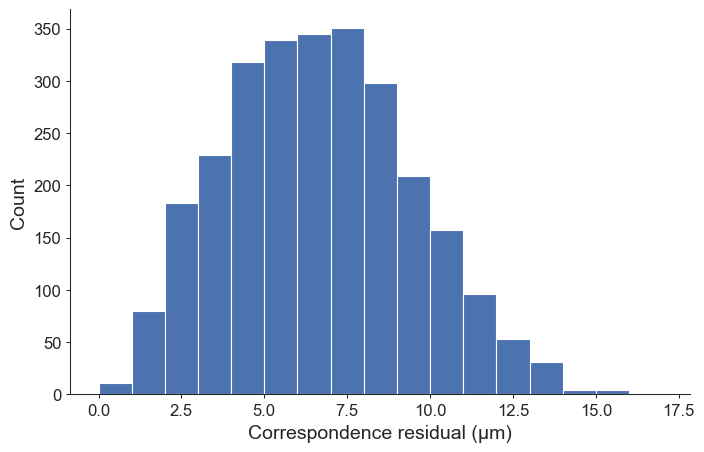

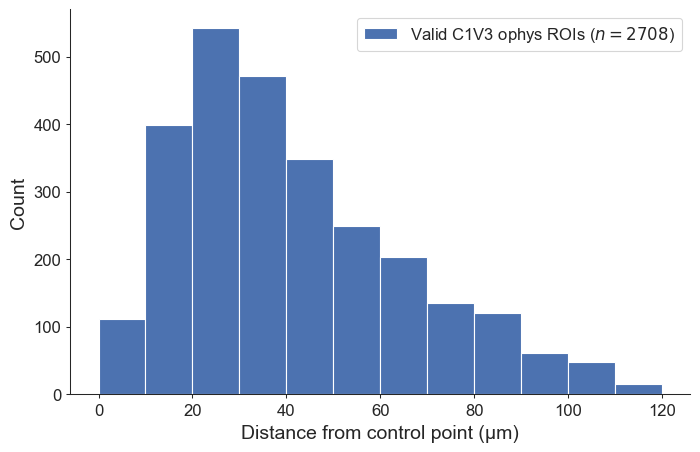

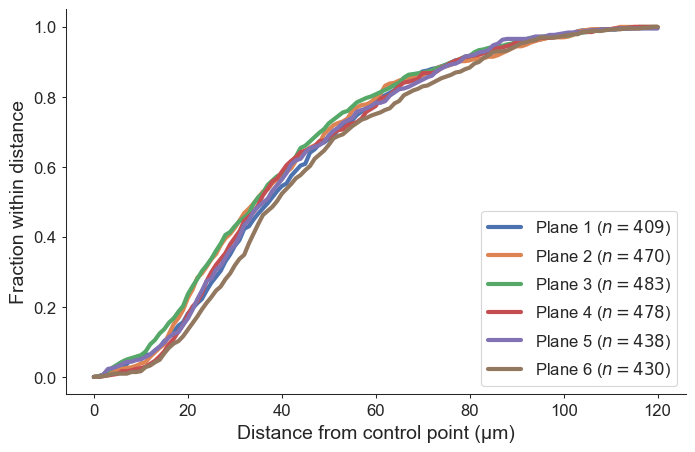

In [8]:
n_valid = coreg_table.ophys_is_roi_valid.sum()

plt.figure(figsize=(8, 5))
# sns.histplot(data=coreg_table[coreg_table.ophys_is_roi_valid], x="correspondence_residual_nm", hue="ophys_plane")
plt.hist(coreg_table.correspondence_residual_nm.values[coreg_table.ophys_is_roi_valid] / 1000, bins=np.arange(0, 18, 1), label=f"Valid C1V3 ophys ROIs ($n = {n_valid}$)")
plt.xlabel("Correspondence residual (µm)")
plt.ylabel("Count")
# plt.legend()

plt.figure(figsize=(8, 5))
plt.hist(coreg_table.ctrl_pt_distance_um.values[coreg_table.ophys_is_roi_valid], bins=np.arange(0, 121, 10), label=f"Valid C1V3 ophys ROIs ($n = {n_valid}$)")
plt.xlabel("Distance from control point (µm)")
plt.ylabel("Count")
plt.legend()

plt.figure(figsize=(8, 5))
d = np.arange(0, 121, 1)

for plane in coreg_table.ophys_plane.unique():
    distances = coreg_table.ctrl_pt_distance_um.values[(coreg_table.ophys_plane == plane) & coreg_table.ophys_is_roi_valid]
    plt.plot(d, [np.mean(distances < dist) for dist in d], linewidth=3, label=f"Plane {plane} ($n = {len(distances)}$)")

# plt.plot(d, [np.mean(coreg_table.ctrl_pt_distance_um.values[~coreg_table.ophys_is_roi_valid] < dist) for dist in d], color="gray", linewidth=2, label=f"Valid C1V3 ophys ROIs ($n = {np.count_nonzero(~coreg_table.ophys_is_roi_valid)}$)")
plt.xlabel("Distance from control point (µm)")
plt.ylabel("Fraction within distance")
plt.legend()

# plt.scatter(coreg_table[coreg_table.ophys_is_roi_valid].correspondence_residual_nm, coreg_table[coreg_table.ophys_is_roi_valid].ctrl_pt_distance_um, color="blue", label="Valid ROI")
# plt.scatter(coreg_table[~coreg_table.ophys_is_roi_valid].correspondence_residual_nm, coreg_table[~coreg_table.ophys_is_roi_valid].ctrl_pt_distance_um, color="gray", label="Invalid ROI")
# plt.plot(color="gray", label="Invalid ROI")
# plt.legend()

In [9]:
nucleus_table = em_client.query_table(V1DDEMClient.NUCLEUS_TABLE)
nucleus_table

,id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,228132,t,458.464831,87485049993200655,864691132737039043,"[632828, 749849, 738270]","[626620, 746124, 78876]","[638493, 753341, 80137]"
1,543247,t,73.345940,106490931167272264,864691132870078055,"[1304922, 977915, 83880]","[1299179, 974035, 8536]","[1311595, 983192, 9511]"
2,203262,t,338.276613,87197526360541948,864691132654552792,"[624680, 531094, 283770]","[619869, 525818, 30089]","[629414, 535750, 31050]"
3,350562,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]"
4,718122,t,333.888647,118515535938912588,864691132774106773,"[1729859, 674111, 781200]","[1722177, 667205, 83852]","[1736610, 682026, 84536]"
...,...,...,...,...,...,...,...,...
207450,527607,t,100.547645,105284974949287046,864691132639606383,"[1262940, 628094, 734445]","[1258827, 624990, 78856]","[1267053, 630810, 79453]"
207451,168582,t,369.919126,83482550844689534,864691133042980384,"[491518, 1057067, 92070]","[485388, 1052877, 9399]","[497571, 1061413, 10389]"
207452,29422,t,285.031368,0,0,"[302330, 415005, 81855]","[294182, 409340, 8410]","[308770, 420825, 9099]"
207453,422767,t,394.724290,99723368244567127,864691132851361283,"[1065603, 538932, 36405]","[1061335, 533267, 3434]","[1070182, 544054, 4399]"


In [10]:
nucleus_table["pt_position_enc"] = nucleus_table["pt_position"].apply(lambda pos: f"[{pos[0]}, {pos[1]}, {pos[2]}]")
position_to_root_id = pd.Series(index=nucleus_table.pt_position_enc.values, data=nucleus_table.pt_root_id.values)
position_to_root_id.head()

[632828, 749849, 738270]     864691132737039043
[1304922, 977915, 83880]     864691132870078055
[624680, 531094, 283770]     864691132654552792
[894573, 478559, 163530]     864691132773514104
[1729859, 674111, 781200]    864691132774106773
dtype: int64

In [11]:
# Add pt_root_id to coreg_table
coreg_table["pt_root_id"] = coreg_table["nucleus_point_nm"].apply(lambda pos: position_to_root_id.get(pos, None))
coreg_table["pt_root_id"]

0       864691132729011259
1       864691132609337272
2       864691132919616779
3       864691132923242281
4       864691132729011259
               ...        
7518    864691132827052402
7519    864691132583967158
7520    864691132664655267
7521    864691132984457824
7522    864691132726402717
Name: pt_root_id, Length: 7523, dtype: int64

In [12]:
coreg_table_valid = coreg_table[coreg_table.ophys_is_roi_valid]
len(coreg_table_valid)

2708

In [13]:
counts = coreg_table_valid.pt_root_id.value_counts()
pt_root_ids_multi = counts.index[counts.values > 1]
len(pt_root_ids_multi)

472

In [14]:
rois_multi = coreg_table_valid.roi.values[coreg_table_valid.pt_root_id.isin(pt_root_ids_multi)]
rois_multi

array(['M409828_13_1_0', 'M409828_13_1_4', 'M409828_13_1_12', ...,
       'M409828_13_6_723', 'M409828_13_6_776', 'M409828_13_6_797'],
      dtype=object)

In [15]:
# Load metrics
metrics_all = at.load_roi_metrics(preprocess=False)
metrics_all.head()

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_1_0,409828,1,1,1,0,False,False,False,0,NaN,...,0.000437,NaN,NaN,NaN,NaN,NaN,NaN,[],0.000337,0.001891
M409828_11_1_1,409828,1,1,1,1,False,False,False,0,NaN,...,0.000682,NaN,NaN,NaN,NaN,NaN,NaN,[],0.000566,0.003059
M409828_11_1_2,409828,1,1,1,2,False,False,False,0,NaN,...,0.000564,NaN,NaN,NaN,NaN,NaN,NaN,[],0.000431,0.002470
M409828_11_1_3,409828,1,1,1,3,False,False,False,0,NaN,...,0.000502,NaN,NaN,NaN,NaN,NaN,NaN,[],0.000416,0.002300
M409828_11_1_4,409828,1,1,1,4,False,False,False,0,NaN,...,0.000571,NaN,NaN,NaN,NaN,NaN,NaN,[],0.000484,0.002612


In [16]:
metrics_all.loc[rois_multi].has_duplicate.mean()

0.5821325648414986

# How much does the ophys duplicate matching overlap with the coregistration duplicate matching?

In [17]:
coreg_table_valid.groupby("pt_root_id")["roi"].unique()

pt_root_id
864691128699154747                    [M409828_13_5_133]
864691129249906587                    [M409828_13_2_153]
864691129393927997                    [M409828_13_2_143]
864691129551534031                    [M409828_13_6_222]
864691129663630455                    [M409828_13_6_356]
                                     ...                
864691133310570064                    [M409828_13_2_570]
864691133310618448                     [M409828_13_4_33]
864691133311300176                    [M409828_13_5_118]
864691133312412496                    [M409828_13_6_237]
864691133312601680    [M409828_13_3_2, M409828_13_3_275]
Name: ophys_roi_lookup, Length: 2139, dtype: object

In [18]:
metrics_all[metrics_all.is_valid & ~metrics_all.is_ignored_duplicate]

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_1_89,409828,1,1,1,89,True,False,False,0,NaN,...,0.000455,0.000710,0.000586,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903
M409828_11_2_0,409828,1,1,2,0,True,False,True,2,"M409828_11_2_0, M409828_11_3_2",...,0.000646,0.000394,0.000911,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629
M409828_11_2_1,409828,1,1,2,1,True,False,True,2,"M409828_11_2_1, M409828_11_3_0",...,0.000532,0.002046,0.009295,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262
M409828_11_2_2,409828,1,1,2,2,True,False,False,0,NaN,...,0.000587,0.000344,0.000369,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412
M409828_11_2_4,409828,1,1,2,4,True,False,False,0,NaN,...,0.000382,0.000221,0.000660,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_1f_1_67,409828,1,f,1,67,True,False,False,0,NaN,...,0.001682,0.001367,0.000335,0.747323,0.855392,-0.219870,-0.494028,"[-1.133123, 0.4198947, -0.50646245, -0.6880275...",0.001101,0.007307
M409828_1f_1_69,409828,1,f,1,69,True,False,False,0,NaN,...,0.002401,0.001279,0.000662,0.812710,0.896679,0.212778,-0.116894,"[-0.044746883, -3.4504194, 0.0044283015, 0.070...",0.001627,0.010508
M409828_1f_1_70,409828,1,f,1,70,True,False,False,0,NaN,...,0.001563,0.001456,0.004045,-0.357205,-1.111411,-0.785375,-0.586742,"[-3.697709, -2.9139242, -1.1114113, -10.827181...",0.001108,0.006967
M409828_1f_1_74,409828,1,f,1,74,True,False,False,0,NaN,...,0.001194,0.001193,0.001233,0.203826,0.338630,-0.274512,-0.390882,"[0.27589533, 0.26011756, 0.116383515, -2.22222...",0.000818,0.005215


In [19]:
metrics_all.n_duplicates.value_counts()

0    49166
2     1880
3      786
4      388
5      305
6      294
7        7
Name: n_duplicates, dtype: int64

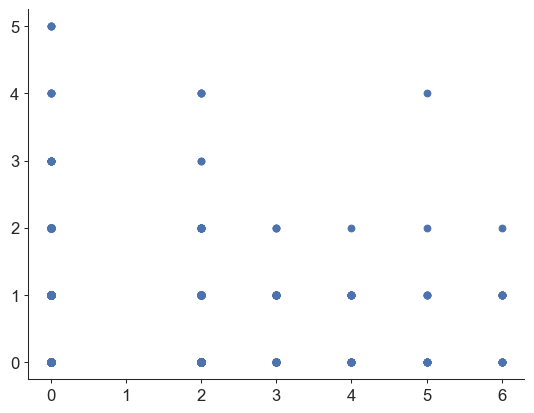

In [20]:
coreg_dups = coreg_table_valid.groupby("pt_root_id")["roi"].unique().values
X = []
Y = []

for roi, row in metrics_all[metrics_all.is_valid & ~metrics_all.is_ignored_duplicate].iterrows():
    if roi in coreg_table_valid.roi.values:
        n_coreg_dups = 0

        for s in coreg_dups:
            if roi in s:
                n_coreg_dups = len(s) - 1
                break

        n_ophys_dups = row["n_duplicates"]

        X.append(n_ophys_dups)
        Y.append(n_coreg_dups)

        # if row["n_duplicates"] == 0:
            
        # else:
        #     for dup_roi in row["duplicate_rois"].split(", "):
        #         pass

plt.scatter(X, Y)

In [21]:
cell_type_table = em_client.get_cell_type_table()

In [22]:
pd.value_counts(cell_type_table.cell_type.values[cell_type_table.pt_root_id.isin(coreg_table_valid[coreg_table_valid.ctrl_pt_distance_um < 20].pt_root_id)])

PYC             193
BC                5
Non-neuronal      2
BPC               1
Unsure I          1
MC                1
NGC               1
dtype: int64

In [23]:
coreg_table_valid

,nucleus_point_nm,ophys_column,ophys_volume,ophys_plane_name,ophys_roi_name,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method,ophys_plane,ophys_roi,ophys_roi_lookup,ophys_is_roi_valid,pt_root_id
0,"[899074, 635466, 83520]",1,3,plane0,roi_0000,"[359.47229551451187, 46.36059806508356, 0.0]",4849.713802,6.498279,1.708822,fit_search_v0.0.1,1,0,M409828_13_1_0,True,864691132729011259
1,"[787485, 606599, 174105]",1,3,plane0,roi_0001,"[188.08246225319394, 165.51335656213706, 0.0]",6490.590771,28.217650,1.646525,fit_search_v0.0.1,1,1,M409828_13_1_1,True,864691132609337272
2,"[902255, 558254, 308655]",1,3,plane0,roi_0002,"[315.91832229580575, 343.1931567328918, 0.0]",10463.777854,31.819328,3.149323,fit_search_v0.0.1,1,2,M409828_13_1_2,True,864691132919616779
3,"[846383, 592942, 209025]",1,3,plane0,roi_0003,"[266.65572139303487, 206.9223880597015, 0.0]",2271.853481,19.021159,3.207205,fit_search_v0.0.1,1,3,M409828_13_1_3,True,864691132923242281
4,"[901324, 636320, 75465]",1,3,plane0,roi_0004,"[356.6945273631841, 32.32935323383085, 0.0]",3436.624502,15.458198,1.923929,fit_search_v0.0.1,1,4,M409828_13_1_4,True,864691132729011259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081,"[676905, 661385, 181395]",1,3,plane5,roi_0706,"[44.097062579821205, 179.3690932311622, 5.0]",5598.083149,105.214744,4.612700,fit_search_v0.0.1,6,706,M409828_13_6_706,True,864691132839749556
7097,"[740692, 685906, 104670]",1,3,plane5,roi_0722,"[136.20558882235528, 75.07385229540918, 5.0]",8230.457138,49.155893,3.440755,fit_search_v0.0.1,6,722,M409828_13_6_722,True,864691132686902792
7098,"[857635, 639502, 270495]",1,3,plane5,roi_0723,"[271.0759330759331, 294.87258687258685, 5.0]",6346.413697,35.137566,3.128867,fit_search_v0.0.1,6,723,M409828_13_6_723,True,864691132655526652
7151,"[859420, 634380, 318690]",1,3,plane5,roi_0776,"[267.1882183908046, 352.83477011494256, 5.0]",3930.940887,41.069965,2.965676,fit_search_v0.0.1,6,776,M409828_13_6_776,True,864691132957028199


# Examine connectivity

In [24]:
# Find cells with high SSI
metrics = at.load_roi_metrics()
metrics = metrics[(metrics.mouse == 409828) & (metrics.column == 1) & (metrics.volume == 3)]
metrics = metrics.reset_index().merge(right=coreg_table, how="left", left_on="index", right_on="roi").set_index("index")
metrics

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method,ophys_plane,ophys_roi,ophys_roi_lookup,ophys_is_roi_valid,pt_root_id
index,,,,,,,,,,,,,,,,,,,,,
M409828_13_1_0,409828,1,3,1,0,True,False,True,2,"M409828_13_1_0, M409828_13_2_214",...,"[359.47229551451187, 46.36059806508356, 0.0]",4849.713802,6.498279,1.708822,fit_search_v0.0.1,1,0,M409828_13_1_0,True,864691132729011259
M409828_13_1_1,409828,1,3,1,1,True,False,True,2,"M409828_13_1_1, M409828_13_2_35",...,"[188.08246225319394, 165.51335656213706, 0.0]",6490.590771,28.217650,1.646525,fit_search_v0.0.1,1,1,M409828_13_1_1,True,864691132609337272
M409828_13_1_2,409828,1,3,1,2,True,False,False,0,NaN,...,"[315.91832229580575, 343.1931567328918, 0.0]",10463.777854,31.819328,3.149323,fit_search_v0.0.1,1,2,M409828_13_1_2,True,864691132919616779
M409828_13_1_3,409828,1,3,1,3,True,False,True,2,"M409828_13_1_3, M409828_13_2_65",...,"[266.65572139303487, 206.9223880597015, 0.0]",2271.853481,19.021159,3.207205,fit_search_v0.0.1,1,3,M409828_13_1_3,True,864691132923242281
M409828_13_1_4,409828,1,3,1,4,True,False,False,0,NaN,...,"[356.6945273631841, 32.32935323383085, 0.0]",3436.624502,15.458198,1.923929,fit_search_v0.0.1,1,4,M409828_13_1_4,True,864691132729011259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,True,False,False,0,NaN,...,"[44.097062579821205, 179.3690932311622, 5.0]",5598.083149,105.214744,4.612700,fit_search_v0.0.1,6,706,M409828_13_6_706,True,864691132839749556
M409828_13_6_722,409828,1,3,6,722,True,False,False,0,NaN,...,"[136.20558882235528, 75.07385229540918, 5.0]",8230.457138,49.155893,3.440755,fit_search_v0.0.1,6,722,M409828_13_6_722,True,864691132686902792
M409828_13_6_723,409828,1,3,6,723,True,False,False,0,NaN,...,"[271.0759330759331, 294.87258687258685, 5.0]",6346.413697,35.137566,3.128867,fit_search_v0.0.1,6,723,M409828_13_6_723,True,864691132655526652


In [25]:
# Measure precision and recall of duplicates
all_roi_names = metrics.index.values

coreg_table_roi_has_duplicate = set()
for rois in coreg_table_valid.groupby("pt_root_id")["roi"].unique().values:
    if len(rois) > 1:
        coreg_table_roi_has_duplicate.update(rois)
coreg_table_roi_has_duplicate.intersection_update(all_roi_names)
print(f"{len(coreg_table_roi_has_duplicate)} ROIs in coreg table have duplicates")

metrics_roi_has_duplicate = metrics.index[metrics.has_duplicate]
print(f"{len(metrics_roi_has_duplicate)} ROIs in metrics table have duplicates")

df = pd.DataFrame(index=all_roi_names, columns=["y_true", "y_pred"], dtype=bool)
df["y_true"] = [roi in metrics_roi_has_duplicate for roi in df.index]
df["y_pred"] = [roi in coreg_table_roi_has_duplicate for roi in df.index]
value_counts = df.value_counts()
tp = value_counts[True, True]
fp = value_counts[True, False]
tn = value_counts[False, False]
fn = value_counts[False, True]

print(value_counts)

print("Precision:", tp / (tp + fp))
print("Recall:", tp / (tp + fn))
print("Accuracy:", (tp + tn) / len(df))


640 ROIs in coreg table have duplicates
508 ROIs in metrics table have duplicates
y_true  y_pred
False   False     958
        True      435
True    False     303
        True      205
dtype: int64
Precision: 0.4035433070866142
Recall: 0.3203125
Accuracy: 0.6117832719621252


<AxesSubplot: xlabel='ssi', ylabel='Count'>

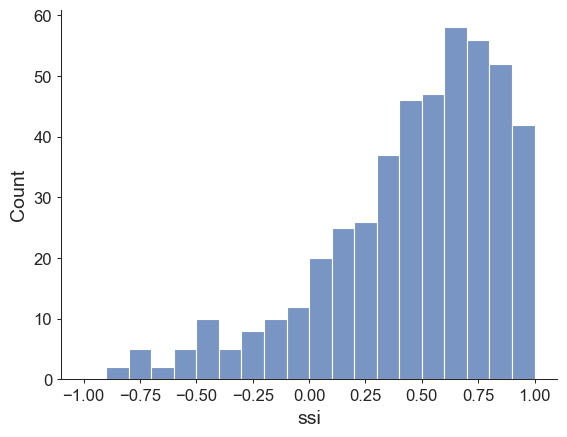

In [26]:
sns.histplot(metrics[metrics.dgw_is_responsive & (metrics.ctrl_pt_distance_um <= 100)], x="ssi", bins=np.arange(-1, 1.1, 0.1))

In [27]:
em_client.get_2p_corresponded_table()

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi_lookup,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",1-3-3-14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,False,not_started,False
1,1,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]",1-3-1-60,"[-72.07225703497906, 349.1430176136275, -317.4...",in_progress,False,in_progress,False
2,2,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]",1-3-2-30,"[-119.78729184255074, 360.70596673244506, -336...",not_started,False,not_started,False
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",1-3-5-119,"[-147.1008040492488, 397.2344828991529, -345.9...",submitted,True,submitted,True
4,4,96,t,session13,plane1_0271,92547337557612090,864691132771662867,"[90300, 66348, 6009]",1-3-2-271,"[-94.38847650736024, 369.8469629730637, -310.8...",in_progress,False,in_progress,False
5,5,37,t,session13,plane2_roi_0269,93109944114777440,864691132807412738,"[92493, 64925, 7372]",1-3-3-269,"[-74.63141709996748, 373.8276859071403, -248.3...",not_started,False,not_started,False
6,6,94,t,session13,plane1_0262,95573468367740795,864691132573738810,"[102044, 67460, 5245]",1-3-2-262,"[11.308402525398183, 369.7604962433013, -346.6...",not_started,False,not_started,False
7,7,39,t,session13,plane2_roi_0158,95150912506684625,864691132594653239,"[100608, 65812, 6828]",1-3-3-158,"[-1.5916540129779606, 374.602796307896, -274.0...",not_started,False,not_started,False
8,8,40,t,session13,plane2_roi_0230,94658606108307469,864691133065754585,"[98584, 67037, 6372]",1-3-3-230,"[-19.781894514350686, 379.8231010230511, -296....",not_started,False,not_started,False
9,9,87,t,session13,plane0_0088,94166024496769248,864691132630689634,"[96758, 67089, 3591]",1-3-1-88,"[-36.38019665927964, 346.8564369779331, -417.4...",not_started,False,not_started,False


In [39]:
corresponded_table = em_client.get_2p_corresponded_table()
corresponded_table.head()

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",M409828_13_3_14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,False,not_started,False
1,1,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]",M409828_13_1_60,"[-72.07225703497906, 349.1430176136275, -317.4...",in_progress,False,in_progress,False
2,2,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]",M409828_13_2_30,"[-119.78729184255074, 360.70596673244506, -336...",not_started,False,not_started,False
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",M409828_13_5_119,"[-147.1008040492488, 397.2344828991529, -345.9...",submitted,True,submitted,True
4,4,96,t,session13,plane1_0271,92547337557612090,864691132771662867,"[90300, 66348, 6009]",M409828_13_2_271,"[-94.38847650736024, 369.8469629730637, -310.8...",in_progress,False,in_progress,False


In [40]:
proofread_corresponded_rois = corresponded_table.roi[corresponded_table.dendrite_proofreading_complete].values

In [41]:
# metrics[metrics.dgw_is_responsive & (metrics.dgw_pref_response > 0.01)].ssi.sort_values(ascending=True).head(30)
responsive_ssi = metrics[metrics.dgw_is_responsive & metrics.dgf_is_responsive & ((metrics.dgw_pref_dir - metrics.dgf_pref_dir).abs() <= 30) & (metrics.index.isin(proofread_corresponded_rois))].ssi
responsive_ssi.sort_values(ascending=True).head(5), len(responsive_ssi)

(index
 M409828_13_3_29   -0.828736
 Name: ssi, dtype: float64,
 1)

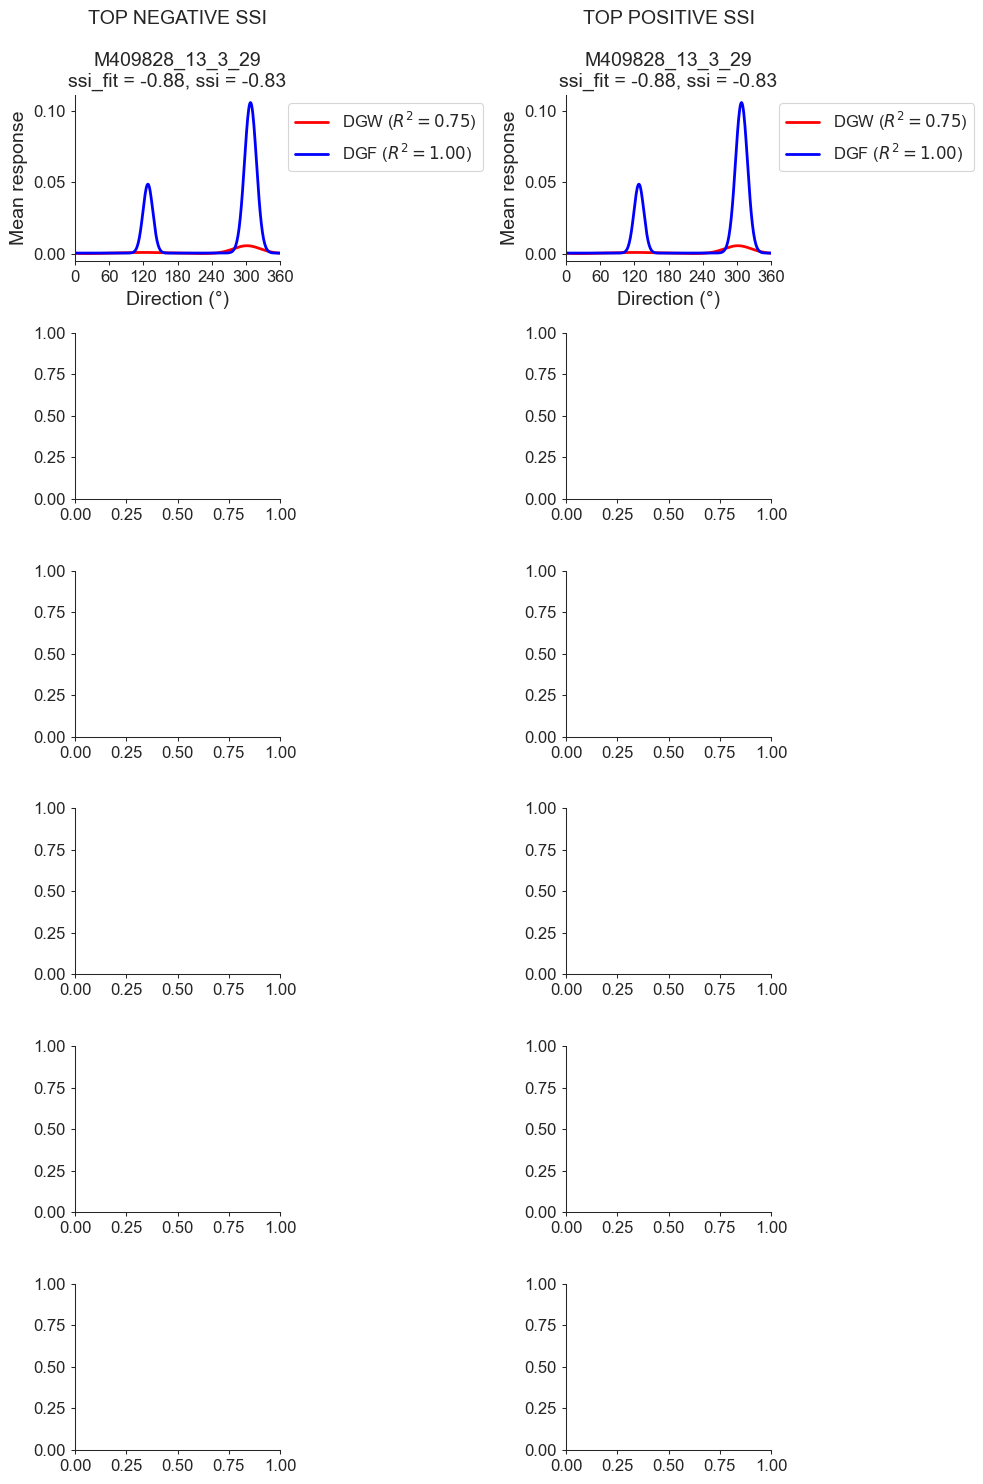

In [42]:
nrows = 6
fig, axs = plt.subplots(figsize=(10, nrows*2.5), nrows=nrows, ncols=2)

# Top negative SSIs
for i, roi in enumerate(responsive_ssi.sort_values(ascending=True).head(nrows).index):
    ax = axs[i, 0]
    at.plot_dg_tuning_curves(metrics, roi, ax=ax, xtick_spacing=60)
    if i == 0:
        ax.set_title(f"TOP NEGATIVE SSI\n\n{ax.get_title()}")

# Top positive SSIs
for i, roi in enumerate(responsive_ssi.sort_values(ascending=False).head(nrows).index):
    ax = axs[i, 1]
    at.plot_dg_tuning_curves(metrics, roi, ax=ax, xtick_spacing=60)
    if i == 0:
        ax.set_title(f"TOP POSITIVE SSI\n\n{ax.get_title()}")
    # ax.set_title(ax.get_title(), fontsize=12)

fig.tight_layout()

# Examine connection probabilities

In [43]:
roi = "M409828_13_3_29" # Strong DGF, weak DGW


In [48]:
coreg_table_valid[coreg_table_valid.roi == roi]

,nucleus_point_nm,ophys_column,ophys_volume,ophys_plane_name,ophys_roi_name,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method,ophys_plane,ophys_roi,ophys_roi_lookup,ophys_is_roi_valid,pt_root_id
2485,"[757531, 605901, 253890]",1,3,plane2,roi_0029,"[140.19797421731124, 272.98342541436466, 2.0]",2689.458397,2.040412,2.770225,fit_search_v0.0.1,3,29,M409828_13_3_29,True,864691132829082994


In [49]:
pt_root_id = 864691132829082994

In [51]:
# Load dendritic synapses
den_syn = em_client.get_dendritic_synapses(pt_root_id)
den_syn

,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,synapse_position_microns,pre_soma_position_voxels,pre_soma_position_microns,post_soma_position_voxels,post_soma_position_microns
0,0,297065866,t,88888644164867572,864691132751204741,88888644164886011,864691132829082994,1111,"[70447, 63134, 7844]","[70456, 63179, 7855]","[70435, 63157, 7855]","[-223.47767006334814, 407.8580073439011, -235....",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
1,1,349098823,t,91069181478615113,864691132723981567,91069181478627303,864691132829082994,435,"[78272, 59954, 4856]","[78302, 60008, 4864]","[78290, 59982, 4860]","[-147.69927343210938, 341.81436132400285, -356...",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
2,2,344019059,t,90155143853104513,864691132902668932,90155143853087863,864691132829082994,445,"[74983, 62629, 6159]","[74955, 62596, 6153]","[74986, 62616, 6159]","[-179.96708537125414, 381.69016873123263, -307...","[641597, 658126, 268380]","[-265.19952814505643, 428.9239305259722, -329....","[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
3,3,330288284,t,90014681376307452,864691133000834761,90014681376303309,864691132829082994,2593,"[74533, 63753, 6702]","[74562, 63779, 6699]","[74565, 63744, 6704]","[-183.6913651775945, 399.342340342377, -286.69...",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
4,4,368381901,t,91351481290262960,864691132035278159,91351481290270969,864691132829082994,4899,"[79412, 62862, 6309]","[79419, 62881, 6318]","[79420, 62895, 6310]","[-136.64366979160883, 386.1257686938186, -300....",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,3155,298129058,t,88677469011653520,864691131907391291,88677469011660347,864691132829082994,1227,"[69790, 62875, 6408]","[69793, 62856, 6413]","[69806, 62871, 6411]","[-230.01017982015225, 387.50124700185694, -296...",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
3132,3156,374895030,t,91984937292554439,864691132531199013,91984937292564924,864691132829082994,5829,"[81713, 63410, 5229]","[81765, 63426, 5238]","[81743, 63442, 5233]","[-113.92715506982478, 378.0965373451831, -349....",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
3133,3157,254403240,t,86918113035208322,864691132356959842,86918113035194455,864691132829082994,1215,"[63355, 62481, 6787]","[63341, 62546, 6772]","[63348, 62507, 6781]","[-292.5867002086196, 389.2399882812328, -280.3...",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."
3134,3158,309678254,t,89311680928532957,864691133218868048,89382049672720264,864691132829082994,967,"[72117, 66411, 5642]","[72157, 66404, 5644]","[72119, 66405, 5637]","[-206.96071654153022, 411.2830975457042, -339....",None,None,"[757531, 605901, 253890]","[-149.53674248821613, 374.14964146964496, -329..."


0       864691132751204741
1       864691132723981567
2       864691132902668932
3       864691133000834761
4       864691132035278159
               ...        
3131    864691131907391291
3132    864691132531199013
3133    864691132356959842
3134    864691133218868048
3135    864691132696916778
Name: pre_pt_root_id, Length: 3136, dtype: int64

In [54]:
root_id_to_roi = coreg_table.groupby("pt_root_id")["roi"].unique()
root_id_to_roi

pt_root_id
0                                                    [M409828_13_6_754]
864691128462320394                 [M409828_13_4_625, M409828_13_4_788]
864691128699154747                 [M409828_13_5_133, M409828_13_5_427]
864691128806266888                 [M409828_13_6_364, M409828_13_6_407]
864691128993977392    [M409828_13_3_1073, M409828_13_4_589, M409828_...
                                            ...                        
864691133311510864                                   [M409828_13_1_584]
864691133311785040                [M409828_13_6_410, M409828_13_6_1041]
864691133312412496                [M409828_13_6_237, M409828_13_6_1132]
864691133312601680    [M409828_13_3_2, M409828_13_3_275, M409828_13_...
864691133312711504                                  [M409828_13_3_1255]
Name: ophys_roi_lookup, Length: 3579, dtype: object

In [59]:
den_syn["pre_pt_root_id"].dropna().apply(lambda root_id: root_id_to_roi.get(root_id, None)).dropna()
# presyn_rois

,index,pre_pt_root_id
0,41,[M409828_13_5_343]
1,42,"[M409828_13_6_21, M409828_13_6_522]"
2,43,"[M409828_13_2_26, M409828_13_2_65, M409828_13_..."
3,84,"[M409828_13_6_270, M409828_13_6_448, M409828_1..."
4,116,"[M409828_13_1_837, M409828_13_1_1032]"
...,...,...
97,2883,"[M409828_13_4_1251, M409828_13_5_190, M409828_..."
98,2983,"[M409828_13_3_151, M409828_13_3_850, M409828_1..."
99,2998,[M409828_13_3_709]
100,2999,"[M409828_13_5_844, M409828_13_5_1001, M409828_..."


In [82]:
# Maps ophys ROI to the non-duplicate, kept ROI
dup_roi_to_kept_roi = {}

for kept_roi, dup_rois in metrics.duplicate_rois.dropna().items():
    for dup_roi in dup_rois.split(", "):
        if dup_roi != kept_roi:
            dup_roi_to_kept_roi[dup_roi] = kept_roi

dup_roi_to_kept_roi

{'M409828_13_2_214': 'M409828_13_1_0',
 'M409828_13_2_35': 'M409828_13_1_1',
 'M409828_13_2_65': 'M409828_13_1_3',
 'M409828_13_2_66': 'M409828_13_1_6',
 'M409828_13_2_70': 'M409828_13_1_8',
 'M409828_13_2_121': 'M409828_13_1_9',
 'M409828_13_2_24': 'M409828_13_1_19',
 'M409828_13_3_385': 'M409828_13_1_19',
 'M409828_13_2_276': 'M409828_13_1_22',
 'M409828_13_2_126': 'M409828_13_1_25',
 'M409828_13_2_191': 'M409828_13_1_26',
 'M409828_13_2_424': 'M409828_13_1_32',
 'M409828_13_2_409': 'M409828_13_1_37',
 'M409828_13_2_255': 'M409828_13_1_40',
 'M409828_13_2_321': 'M409828_13_1_43',
 'M409828_13_2_209': 'M409828_13_1_47',
 'M409828_13_2_85': 'M409828_13_1_72',
 'M409828_13_2_80': 'M409828_13_1_87',
 'M409828_13_2_134': 'M409828_13_1_88',
 'M409828_13_3_705': 'M409828_13_1_88',
 'M409828_13_4_708': 'M409828_13_1_88',
 'M409828_13_2_646': 'M409828_13_1_89',
 'M409828_13_2_167': 'M409828_13_1_102',
 'M409828_13_2_327': 'M409828_13_1_103',
 'M409828_13_2_487': 'M409828_13_1_105',
 'M409828_

In [85]:
presyn_rois = []

for pre_pt_root_id in den_syn.pre_pt_root_id.values:
    if pre_pt_root_id in root_id_to_roi:
        for presyn_roi in root_id_to_roi.get(pre_pt_root_id):
            # Find the unique version
            presyn_rois.append(dup_roi_to_kept_roi.get(presyn_roi, presyn_roi))

pd.value_counts(presyn_rois)

M409828_13_5_32      13
M409828_13_5_343     12
M409828_13_6_270     10
M409828_13_6_448     10
M409828_13_6_1082    10
                     ..
M409828_13_5_494      1
M409828_13_4_590      1
M409828_13_6_1094     1
M409828_13_6_882      1
M409828_13_5_850      1
Length: 126, dtype: int64

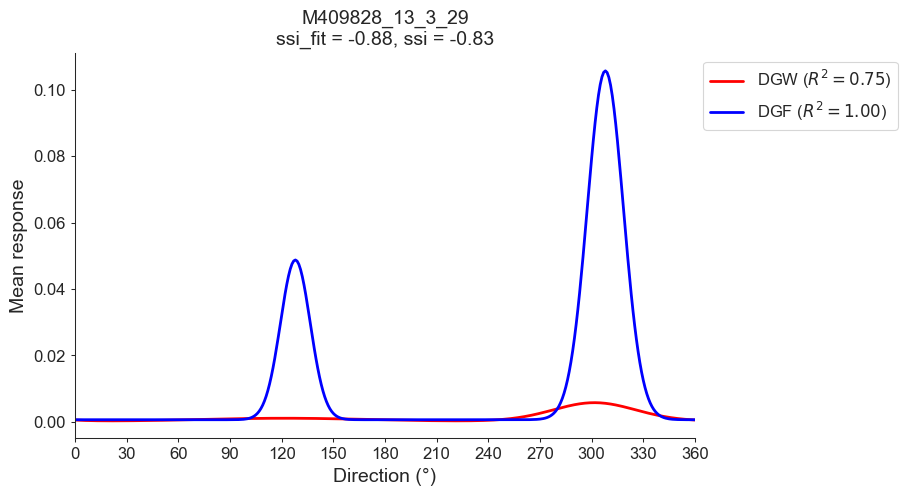

In [86]:
at.plot_dg_tuning_curves(metrics, roi)

<BarContainer object of 14 artists>

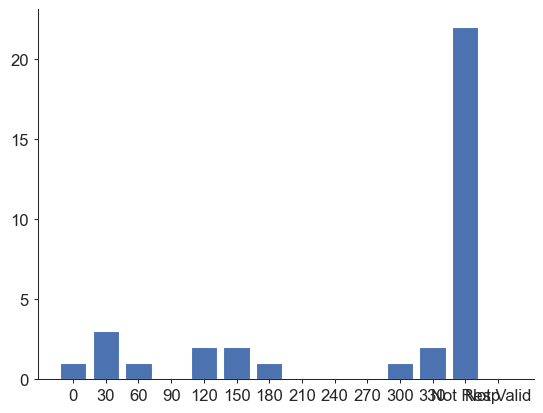

In [99]:
dg_type = "dgf"
dg_type_other = "dgw"
dgf_pref_dir = int(metrics.at[roi, f"{dg_type}_pref_dir"])
not_responsive_key = "Not Resp"
not_valid_key = "Not Valid"
bar_labels = list(range(0, 360, 30)) + [not_responsive_key, not_valid_key]
presyn_pref_dirs = { key: 0 for key in bar_labels }

for presyn_roi in np.unique(presyn_rois):
# for presyn_roi in presyn_rois:
    if not metrics_all.at[presyn_roi, "is_valid"]:
        # presyn_pref_dirs[not_valid_key] += 1
        pass
    elif metrics.at[presyn_roi, f"{dg_type}_frac_responsive_trials"] >= 0.5:
        presyn_pref_dirs[int(metrics.at[presyn_roi, f"{dg_type}_pref_dir"])] += 1
    elif metrics.at[presyn_roi, f"{dg_type_other}_frac_responsive_trials"] >= 0.5:
        presyn_pref_dirs[int(metrics.at[presyn_roi, f"{dg_type_other}_pref_dir"])] += 1
    else:
        presyn_pref_dirs[not_responsive_key] += 1

plt.bar([str(x) for x in bar_labels], [presyn_pref_dirs[x] for x in bar_labels])

In [149]:
corresponded_table

,index,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,roi,position_microns,axon_proofreading_status,axon_proofreading_complete,dendrite_proofreading_status,dendrite_proofreading_complete
0,0,90,t,session13,plane2_014,92055099945608124,864691132710145793,"[88274, 67650, 5900]",M409828_13_3_14,"[-112.57258685416217, 379.9149525558736, -318....",not_started,False,not_started,False
1,1,55,t,session13,plane0_roi_0060,93180175218572599,864691132760377194,"[92791, 64340, 5745]",M409828_13_1_60,"[-72.07225703497906, 349.1430176136275, -317.4...",in_progress,False,in_progress,False
2,2,43,t,session13,plane1_roi_0030,91843650048621008,864691132720617684,"[87483, 66110, 5411]",M409828_13_2_30,"[-119.78729184255074, 360.70596673244506, -336...",not_started,False,not_started,False
3,3,95,t,session13,plane4_0119,91070624654826905,864691132741334425,"[84428, 70297, 5418]",M409828_13_5_119,"[-147.1008040492488, 397.2344828991529, -345.9...",submitted,True,submitted,True
4,4,96,t,session13,plane1_0271,92547337557612090,864691132771662867,"[90300, 66348, 6009]",M409828_13_2_271,"[-94.38847650736024, 369.8469629730637, -310.8...",in_progress,False,in_progress,False
5,5,37,t,session13,plane2_roi_0269,93109944114777440,864691132807412738,"[92493, 64925, 7372]",M409828_13_3_269,"[-74.63141709996748, 373.8276859071403, -248.3...",not_started,False,not_started,False
6,6,94,t,session13,plane1_0262,95573468367740795,864691132573738810,"[102044, 67460, 5245]",M409828_13_2_262,"[11.308402525398183, 369.7604962433013, -346.6...",not_started,False,not_started,False
7,7,39,t,session13,plane2_roi_0158,95150912506684625,864691132594653239,"[100608, 65812, 6828]",M409828_13_3_158,"[-1.5916540129779606, 374.602796307896, -274.0...",not_started,False,not_started,False
8,8,40,t,session13,plane2_roi_0230,94658606108307469,864691133065754585,"[98584, 67037, 6372]",M409828_13_3_230,"[-19.781894514350686, 379.8231010230511, -296....",not_started,False,not_started,False
9,9,87,t,session13,plane0_0088,94166024496769248,864691132630689634,"[96758, 67089, 3591]",M409828_13_1_88,"[-36.38019665927964, 346.8564369779331, -417.4...",not_started,False,not_started,False


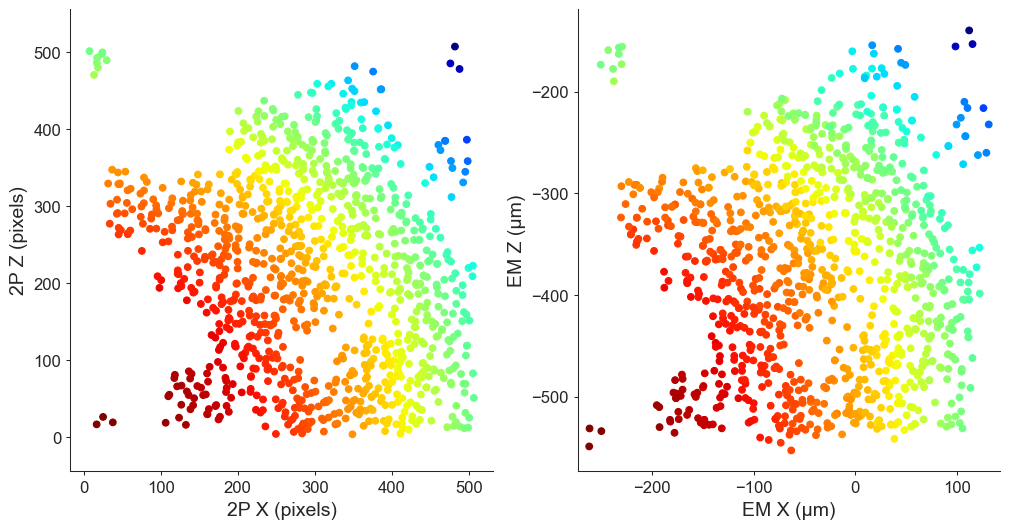

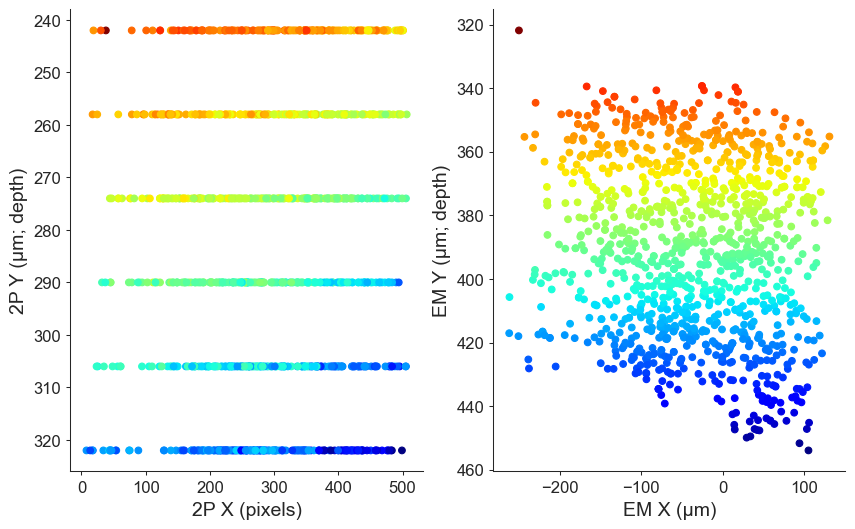

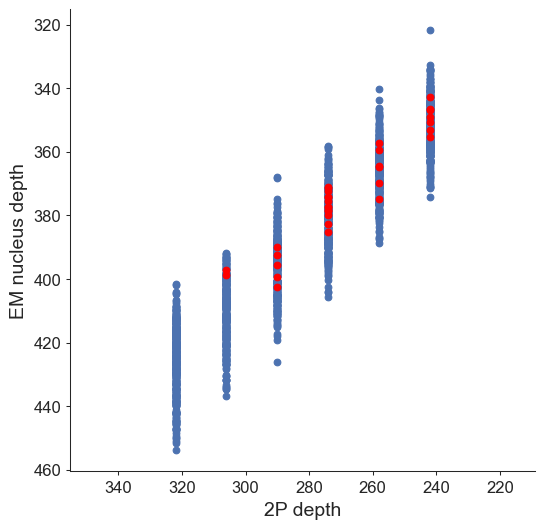

In [202]:
ophys_roi_point = np.vstack(metrics.ophys_roi_point.apply(eval).values)
ophys_roi_point[:, 2] = metrics.depth.values
em_nucleus_point = em_client.transform_position_to_microns(np.vstack(metrics.nucleus_point_nm.apply(eval).values))
confident_mask = metrics.ctrl_pt_distance_um < 40
validated_mask = metrics.index.isin(corresponded_table.roi)
all_mask = metrics.index

# mask = all_mask
mask = confident_mask

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
c = np.sum(np.square(ophys_roi_point[mask, :2]), axis=1)
# c = np.arange(mask.sum())
# np.random.shuffle(c)
axs[0].scatter(ophys_roi_point[mask, 0], ophys_roi_point[mask, 1], c=c, cmap="jet_r")
axs[0].set_xlabel("2P X (pixels)")
axs[0].set_ylabel("2P Z (pixels)")
axs[0].axis("equal")
axs[1].scatter(em_nucleus_point[mask, 0], em_nucleus_point[mask, 2], c=c, cmap="jet_r")
axs[1].set_xlabel("EM X (µm)")
axs[1].set_ylabel("EM Z (µm)")
axs[1].axis("equal")

fig, axs = plt.subplots(figsize=(10, 6), ncols=2)
# c = np.sum(np.square(ophys_roi_point[mask, 0:3:2]), axis=1) # columns 0 and 2
c = em_nucleus_point[mask, 1]
axs[0].scatter(ophys_roi_point[mask, 0], ophys_roi_point[mask, 2], c=c, cmap="jet_r")
axs[0].set_xlabel("2P X (pixels)")
axs[0].set_ylabel("2P Y (µm; depth)")
axs[0].invert_yaxis()
# axs[0].axis("equal")
axs[1].scatter(em_nucleus_point[mask, 0], em_nucleus_point[mask, 1], c=c, cmap="jet_r")
axs[1].set_xlabel("EM X (µm)")
axs[1].set_ylabel("EM Y (µm; depth)")
axs[1].invert_yaxis()
# axs[1].axis("equal")

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(ophys_roi_point[:, 2], em_nucleus_point[:, 1])
ax.scatter(ophys_roi_point[validated_mask, 2], em_nucleus_point[validated_mask, 1], color="red")
ax.axis("equal")
ax.set_xlabel("2P depth")
ax.set_ylabel("EM nucleus depth")
ax.invert_yaxis()
ax.invert_xaxis()

In [171]:
metrics.columns[-15:]

Index(['nucleus_point_nm', 'ophys_column', 'ophys_volume', 'ophys_plane_name',
       'ophys_roi_name', 'ophys_roi_point', 'correspondence_residual_nm',
       'ctrl_pt_distance_um', 'fit_expectation_um', 'corr_method',
       'ophys_plane', 'ophys_roi', 'ophys_roi_lookup', 'ophys_is_roi_valid',
       'pt_root_id'],
      dtype='object')

In [263]:
coreg_table_valid.dendrite_proofreading_complete

AttributeError: 'DataFrame' object has no attribute 'dendrite_proofreading_complete'

In [266]:
den_prf = em_client.get_dendrite_proofreading_table()
proofread_dendrite_root_ids = den_prf.pt_root_id.values[den_prf.complete]
print(f"There are {len(proofread_dendrite_root_ids)} root_ids with proofread dendrites")

There are 2433 root_ids with proofread dendrites


In [275]:
metrics[metrics.dgw_is_responsive & metrics.pt_root_id.isin(proofread_dendrite_root_ids) & (metrics.ctrl_pt_distance_um < 50)]

,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,ophys_roi_point,correspondence_residual_nm,ctrl_pt_distance_um,fit_expectation_um,corr_method,ophys_plane,ophys_roi,ophys_roi_lookup,ophys_is_roi_valid,pt_root_id
index,,,,,,,,,,,,,,,,,,,,,
M409828_13_1_37,409828,1,3,1,37,True,False,True,2,"M409828_13_1_37, M409828_13_2_409",...,"[285.855421686747, 186.82463186077644, 0.0]",2367.240972,27.977039,3.602657,fit_search_v0.0.1,1,37,M409828_13_1_37,True,864691132751584812
M409828_13_1_41,409828,1,3,1,41,True,False,False,0,NaN,...,"[204.4177897574124, 383.6711590296496, 0.0]",1362.003025,34.709129,7.620877,fit_search_v0.0.1,1,41,M409828_13_1_41,True,864691132828635697
M409828_13_1_143,409828,1,3,1,143,True,False,False,0,NaN,...,"[298.8111111111111, 355.32444444444445, 0.0]",10537.875176,30.066257,2.446805,fit_search_v0.0.1,1,143,M409828_13_1_143,True,864691132715725019
M409828_13_1_170,409828,1,3,1,170,True,False,False,0,NaN,...,"[397.45394736842104, 156.67434210526315, 0.0]",6810.015999,41.811058,3.830554,fit_search_v0.0.1,1,170,M409828_13_1_170,True,864691132729591404
M409828_13_1_411,409828,1,3,1,411,True,False,False,0,NaN,...,"[275.6117496807152, 352.76245210727967, 0.0]",4528.136253,29.013128,1.531635,fit_search_v0.0.1,1,411,M409828_13_1_411,True,864691132739886233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_381,409828,1,3,6,381,True,False,True,2,"M409828_13_5_262, M409828_13_6_381",...,"[241.41536458333334, 331.9921875, 5.0]",4582.775404,35.565460,2.969908,fit_search_v0.0.1,6,381,M409828_13_6_381,True,864691132821235561
M409828_13_6_388,409828,1,3,6,388,True,False,False,0,NaN,...,"[348.20588235294116, 294.2366946778711, 5.0]",4497.497797,13.456364,7.322056,fit_search_v0.0.1,6,388,M409828_13_6_388,True,864691132655485143
M409828_13_6_404,409828,1,3,6,404,True,False,False,0,NaN,...,"[460.9880418535127, 275.08370702541106, 5.0]",10129.247295,42.468056,17.992137,fit_search_v0.0.1,6,404,M409828_13_6_404,True,864691132818815231


In [279]:
# corresponded_table = em_client.get_2p_corresponded_table()
# corresponded_den_pt_root_ids = corresponded_table.pt_root_id.values[corresponded_table.dendrite_proofreading_complete]

corresponded_den_pt_root_ids = metrics[metrics.dgw_is_responsive & metrics.pt_root_id.isin(proofread_dendrite_root_ids)].pt_root_id
print(len(corresponded_den_pt_root_ids))

80


In [280]:
all_synapses = em_client.get_dendritic_synapses(corresponded_den_pt_root_ids)

In [281]:
all_synapses

,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,synapse_position_microns,pre_soma_position_voxels,pre_soma_position_microns,post_soma_position_voxels,post_soma_position_microns
0,0,429935482,t,94446194272714021,864691132770688693,94446194272720868,864691132739886233,469,"[90751, 57292, 6814]","[90788, 57299, 6813]","[90774, 57294, 6813]","[-26.59573654629674, 339.37075548560824, -264....",None,None,"[863455, 563997, 322020]","[-43.724245813681975, 351.4854944386772, -252...."
1,1,531726691,t,98389248792827862,864691132502459046,98389248792836145,864691132610254715,805,"[105028, 66202, 4275]","[105072, 66203, 4277]","[105056, 66210, 4278]","[112.21951128049788, 391.3487175732134, -398.0...",None,None,"[945246, 605978, 253980]","[38.17642120276485, 373.3135425256747, -329.04..."
2,2,396360183,t,92549949233224130,864691132360194075,92549949233221535,864691132669158056,1005,"[83706, 71126, 8564]","[83650, 71161, 8558]","[83668, 71137, 8557]","[-95.08397155401995, 490.28804830610136, -225....",None,None,"[866482, 629336, 339255]","[-40.36095296838216, 419.0376883971539, -253.1..."
3,3,462978007,t,95291993592691475,864691132572870047,95291993592703033,864691132610254715,648,"[93734, 62540, 7087]","[93764, 62506, 7102]","[93755, 62508, 7094]","[2.5306700167992386, 391.3723481835227, -265.9...",None,None,"[945246, 605978, 253980]","[38.17642120276485, 373.3135425256747, -329.04..."
4,4,589161335,t,100219935653203651,864691132660146017,100219935653211923,864691132928612072,2774,"[111697, 70515, 4388]","[111697, 70521, 4395]","[111708, 70543, 4395]","[176.68916879782233, 432.80579664660314, -404....",None,None,"[1021216, 702125, 103455]","[114.40603247810913, 425.27920875052666, -499...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172909,174825,375916456,t,91907353070730123,864691131831299321,91907353070737841,864691132691297528,1526,"[81533, 36587, 6051]","[81566, 36599, 6056]","[81555, 36578, 6052]","[-117.05640613039432, 137.2374389048711, -244....",None,None,"[829234, 597908, 268560]","[-77.85341803083837, 370.0184556819857, -312.8..."
172910,174826,467226165,t,95502962386268737,864691132669560752,95502962386247876,864691132606650309,496,"[94533, 61864, 7104]","[94579, 61869, 7093]","[94564, 61853, 7097]","[10.405898466106388, 385.27125358941373, -264....",None,None,"[900238, 615523, 291870]","[-6.734756673139636, 392.8766916979683, -295.0..."
172911,174827,445400016,t,94729730967876161,864691132803073382,94729730967877187,864691132835126165,4161,"[91675, 65086, 7778]","[91699, 65038, 7779]","[91668, 65068, 7780]","[-17.341197014229255, 423.2908544703971, -243....",None,None,"[871836, 585337, 318105]","[-35.24621969533723, 370.9567484414983, -261.7..."
172912,174828,491719983,t,96560348974613133,864691132930939112,96489980230461568,864691132703795329,239,"[98264, 68974, 6933]","[98206, 68914, 6943]","[98230, 68949, 6939]","[45.90610998201591, 449.1310505266952, -289.45...","[985675, 772974, 393030]","[79.59111024658277, 571.2334390475582, -239.77...","[897677, 631586, 336510]","[-9.159206036296789, 420.31547748300375, -256...."


In [282]:
cell_type_col = all_synapses.merge(cell_type_table[["cell_type", "pt_root_id"]], how="left", left_on="pre_pt_root_id", right_on="pt_root_id")["cell_type"]
all_synapses["pre_cell_type"] = cell_type_col
all_synapses.head()

,index,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,synapse_position_microns,pre_soma_position_voxels,pre_soma_position_microns,post_soma_position_voxels,post_soma_position_microns,pre_cell_type
0,0,429935482,t,94446194272714021,864691132770688693,94446194272720868,864691132739886233,469,"[90751, 57292, 6814]","[90788, 57299, 6813]","[90774, 57294, 6813]","[-26.59573654629674, 339.37075548560824, -264....",None,None,"[863455, 563997, 322020]","[-43.724245813681975, 351.4854944386772, -252....",NaN
1,1,531726691,t,98389248792827862,864691132502459046,98389248792836145,864691132610254715,805,"[105028, 66202, 4275]","[105072, 66203, 4277]","[105056, 66210, 4278]","[112.21951128049788, 391.3487175732134, -398.0...",None,None,"[945246, 605978, 253980]","[38.17642120276485, 373.3135425256747, -329.04...",NaN
2,2,396360183,t,92549949233224130,864691132360194075,92549949233221535,864691132669158056,1005,"[83706, 71126, 8564]","[83650, 71161, 8558]","[83668, 71137, 8557]","[-95.08397155401995, 490.28804830610136, -225....",None,None,"[866482, 629336, 339255]","[-40.36095296838216, 419.0376883971539, -253.1...",NaN
3,3,462978007,t,95291993592691475,864691132572870047,95291993592703033,864691132610254715,648,"[93734, 62540, 7087]","[93764, 62506, 7102]","[93755, 62508, 7094]","[2.5306700167992386, 391.3723481835227, -265.9...",None,None,"[945246, 605978, 253980]","[38.17642120276485, 373.3135425256747, -329.04...",NaN
4,4,589161335,t,100219935653203651,864691132660146017,100219935653211923,864691132928612072,2774,"[111697, 70515, 4388]","[111697, 70521, 4395]","[111708, 70543, 4395]","[176.68916879782233, 432.80579664660314, -404....",None,None,"[1021216, 702125, 103455]","[114.40603247810913, 425.27920875052666, -499....",NaN


In [287]:
print(all_synapses.pre_cell_type.value_counts(dropna=False))
print()
print(all_synapses[~all_synapses.pre_soma_position_voxels.isna()].pre_cell_type.value_counts(dropna=False))

NaN             163688
BC                3662
MC                3381
PYC               1385
Unsure I           442
Non-neuronal       176
BPC                142
NGC                 38
Name: pre_cell_type, dtype: int64

NaN             9640
BC              3662
MC              3381
PYC             1385
Unsure I         442
Non-neuronal     176
BPC              142
NGC               38
Name: pre_cell_type, dtype: int64


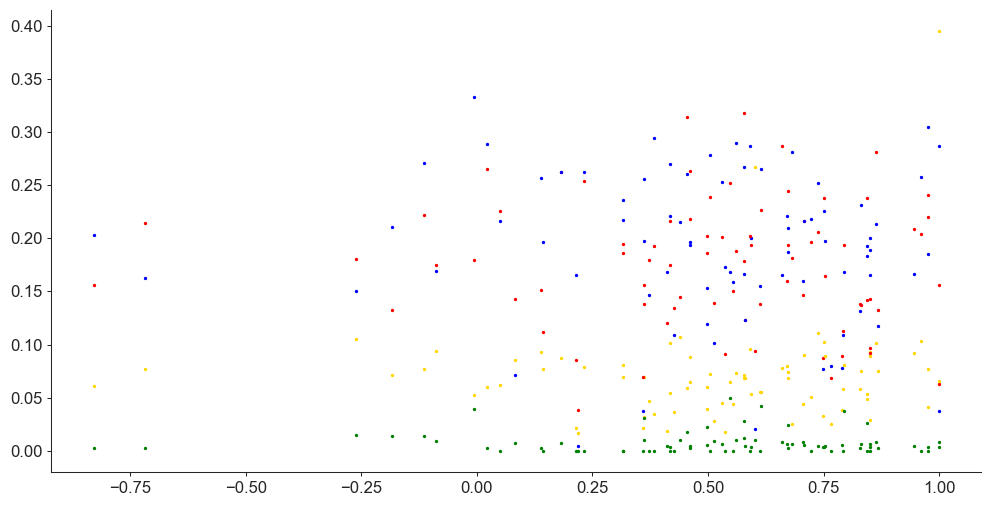

In [298]:
fig, ax = plt.subplots(figsize=(12, 6))

for root_id in all_synapses.post_pt_root_id.unique():
    synapses = all_synapses[all_synapses.post_pt_root_id == root_id]
    synapses = synapses[~synapses.pre_soma_position_voxels.isna()] # only include synapses in the volume
    roi = coreg_table_valid.roi[coreg_table_valid.pt_root_id == root_id].iloc[0]
    presyn_cell_type_counts = synapses.pre_cell_type.value_counts(dropna=False)

    x = metrics_all.at[roi, "ssi"]
    # y = presyn_cell_type_counts["MC"] / len(synapses)
    # y = presyn_cell_type_counts["MC"] / presyn_cell_type_counts["PYC"]

    for cell_type, color in (("MC", "red"), ("PYC", "gold"), ("BC", "blue"), ("BPC", "green")):
        ax.scatter(x, presyn_cell_type_counts.get(cell_type, 0) / len(synapses), marker=".", s=10, color=color)

    # print(root_id, len(synapses))
    # print()
    # print()


    y_lb, y_ub = 0, 0
    # y_lb = (presyn_cell_type_counts["MC"] / )
    # y_ub = (presyn_cell_type_counts["MC"] + presyn_cell_type_counts[np.nan]) / len(synapses)
    
    # ax.errorbar(x, y, yerr=[[0 if y_lb == 0 else y_lb - y], [0 if y_ub == 0 else y_ub - y]], marker=".", markersize=10, color="black")

